In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, average_precision_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, roc_auc_score
from tqdm.auto import tqdm

from graph import _get_genes, _get_phenotypes, _get_positive_negative_edges, _load_gen_df, _load_phn_df, _merge_dfs

In [2]:
df = pd.read_csv('results.csv')
df

,Gen,Phn,p
0,ERCC1,D1071,0.999487
1,DDX54,D1071,0.988706
2,SNCAIP,D1071,0.837623
3,DNMT3A,D1071,0.943749
4,PAICS,D1071,0.666698
...,...,...,...
965803,ITPKB,D1158,0.000000
965804,Mar-05,D1158,0.000000
965805,MORF4,D1158,0.000000
965806,STK32C,D1158,0.000000


In [3]:
df_gen = _load_gen_df()
df_phn = _load_phn_df()

genes = _get_genes(df_gen, df_phn)
phenotypes = _get_phenotypes(df_phn)

positive_edges, _ = _get_positive_negative_edges(_merge_dfs(df_gen, df_phn), genes, phenotypes)
positive_edges = pd.DataFrame({'Gen': positive_edges['Nod_B'], 'Phn': positive_edges['Nod_A'], 'GT': 1})
positive_edges

,Gen,Phn,GT
0,MAP3K4-AS1,D1071,1
1,MAP3K4,D1071,1
2,CDKN2B-AS1,D1071,1
3,NAA25,D1071,1
4,RPS16P9,D1071,1
...,...,...,...
890007,NCKAP1,D1095,1
906293,PPP1R13B,D1222,1
914253,ATP5MJ,D1222,1
914254,TDRD9,D1222,1


In [4]:
df = pd.merge(df, positive_edges, on=['Gen', 'Phn'], how='left').fillna(0)
df['GT'] = df['GT'].astype(int)
df

,Gen,Phn,p,GT
0,ERCC1,D1071,0.999487,1
1,DDX54,D1071,0.988706,1
2,SNCAIP,D1071,0.837623,1
3,DNMT3A,D1071,0.943749,1
4,PAICS,D1071,0.666698,1
...,...,...,...,...
965803,ITPKB,D1158,0.000000,0
965804,Mar-05,D1158,0.000000,0
965805,MORF4,D1158,0.000000,0
965806,STK32C,D1158,0.000000,0


Plot probability distribution returned by the model:

<AxesSubplot:>

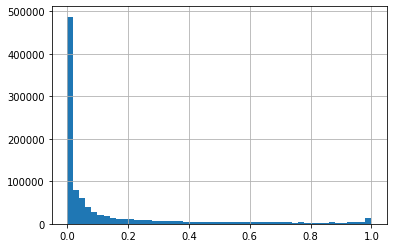

In [5]:
df['p'].hist(bins=50)

Compute performance metrics across all cross-validation folds:

In [6]:
y_test = df['GT'].values
y_prob = df['p'].values
y_pred = (y_prob > 0.5).astype(int)

{
    'Acc': np.round(accuracy_score(y_test, y_pred), 4),
    'BAC': np.round(balanced_accuracy_score(y_test, y_pred), 4),
    'Precision': np.round(precision_score(y_test, y_pred), 4),
    'Recall': np.round(recall_score(y_test, y_pred), 4),
    'PR-AUC': np.round(average_precision_score(y_test, y_prob), 4),
    'AUC': np.round(roc_auc_score(y_test, y_prob), 4),
}

{'Acc': 0.9059,
 'BAC': 0.8821,
 'Precision': 0.0878,
 'Recall': 0.8577,
 'PR-AUC': 0.4361,
 'AUC': 0.9499}

Plot confusion matrix, with probability threshold for link prediction = 0.5:

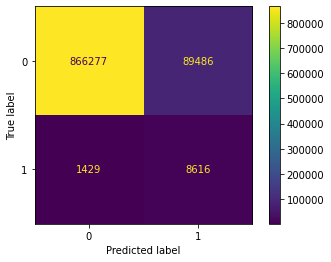

In [7]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Plot confusion matrix, with probability threshold for link prediction = 0.9:

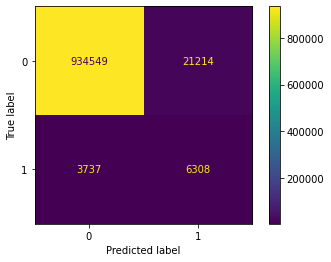

In [8]:
cm = confusion_matrix(y_test, (y_prob > 0.9).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Split dataframe into known (`df_o`) and unknown (`df_n`) links:

In [9]:
df_o = df[df['GT'] == 1].copy()
df_o

,Gen,Phn,p,GT
0,ERCC1,D1071,0.999487,1
1,DDX54,D1071,0.988706,1
2,SNCAIP,D1071,0.837623,1
3,DNMT3A,D1071,0.943749,1
4,PAICS,D1071,0.666698,1
...,...,...,...,...
774651,ZSWIM8,D1595,0.523199,1
774653,TES,D1094,0.529726,1
774654,TMOD1,D1094,0.745336,1
774655,TFEC,D1094,0.029007,1


For unknown links also compute the hits at both thresholds (0.5 and 0.9):

In [10]:
df_n = df[df['GT'] == 0].copy()
df_n['h.5'] = (df_n['p'] > 0.5).astype(int)
df_n['h.9'] = (df_n['p'] > 0.9).astype(int)
df_n

,Gen,Phn,p,GT,h.5,h.9
2000,ZBTB20,D1597,0.000041,0,0,0
2010,CBL,D1071,0.999089,0,1,1
2011,MC2R,D1071,0.992728,0,1,1
2012,APP,D1071,0.999694,0,1,1
2013,LSM4,D1071,0.873146,0,1,0
...,...,...,...,...,...,...
965803,ITPKB,D1158,0.000000,0,0,0
965804,Mar-05,D1158,0.000000,0,0,0
965805,MORF4,D1158,0.000000,0,0,0
965806,STK32C,D1158,0.000000,0,0,0


Count the number of known links per phenotype:

In [11]:
df_o['Phn'].value_counts()

D1071    1105
D1251    1022
D1249    1003
D1075     752
D1536     494
         ... 
D1312       3
D1074       3
D1095       1
D1154       1
D1280       1
Name: Phn, Length: 72, dtype: int64

Count the number of predicted unknown links per phenotype:

In [12]:
df_n.groupby('Phn')[['h.5', 'h.9']].agg('sum').reset_index()

,Phn,h.5,h.9
0,C1007,406,164
1,C1010,947,351
2,C1052,1016,61
3,C1067,664,267
4,C1068,789,311
...,...,...,...
71,L2003,466,55
72,L2004,693,262
73,L2005,690,294
74,L2006,601,238


In [13]:
counts = df_n.groupby('Phn')[['h.5', 'h.9']].agg('sum')
counts = counts.merge(df_o['Phn'].value_counts().to_frame(), left_index=True, right_index=True)
counts = counts.rename(columns={'Phn': '# of known edges'})
counts = counts[['# of known edges', 'h.5', 'h.9']]
counts = counts.sort_values('# of known edges', ascending=False)

print(counts.to_string())

        # of known edges    h.5   h.9
D1071               1105  11346  2303
D1251               1022   2926   825
D1249               1003   2885   815
D1075                752   2079   721
D1536                494   4232  1028
D1250                482   1521   718
D1416                396   1454   709
D1245                372   2302   855
D1153                369   1467   675
ModDRm               334   9202   791
HumAge               307   4975   264
D1524                295   1418   685
HumCel               279   7264   469
D1155                263   1361   665
D1284                259   1385   646
D1526                221   3681   384
D1269                157   1404   642
C1010                153    947   351
C1068                115    789   311
D1523                111   1110   359
C1069                110    757   332
D1085                 87    397   205
D1112                 79    350   209
C1067                 68    664   267
D1182                 66   1064   497
D1183       

Create dataframe containing probability matrix of predicted link probability between genes and phenotypes:

In [14]:
rows = []

for gene in tqdm(genes):
    row = []
    
    ds = df[df['Gen'] == gene]
    
    for phenotype in phenotypes:
        dx = ds[ds['Phn'] == phenotype]
        
        assert len(dx) == 1
        
        if dx['GT'].iloc[0] == 1:
            row.append(np.nan)
        else:
            row.append(dx['p'].iloc[0])
    
    rows.append(row)

dm = pd.DataFrame(rows, columns=phenotypes)
dm

  0%|          | 0/12703 [00:00<?, ?it/s]

,D1071,HumCel,D1536,D1251,D1249,D1526,ModDRm,D1091,D1092,D1082,...,D1351,D1595,D1154,D1218,D1304,D1094,D1280,D1518,D1095,D1222
0,NaN,0.314145,NaN,1.000000,0.999998,0.698466,0.240871,NaN,NaN,NaN,...,0.430494,0.753724,0.000588,0.000000,0.024921,0.656193,0.000000,0.015239,0.029064,0.000000
1,NaN,0.380009,NaN,1.000000,1.000000,0.663671,0.430976,NaN,NaN,NaN,...,0.285652,0.829509,0.056490,0.004679,0.254340,0.255317,0.000000,0.000141,0.000000,0.000182
2,NaN,0.262713,0.999895,1.000000,0.999998,0.986680,0.262452,NaN,NaN,NaN,...,0.607822,0.938560,0.082235,0.002987,0.408010,0.400176,0.000715,0.031443,0.001294,0.003735
3,NaN,0.136577,0.999391,NaN,NaN,0.977843,0.395403,0.982719,0.995348,0.795090,...,0.877482,0.821989,0.446359,0.000000,0.018365,0.996998,0.000000,0.025744,0.039472,0.012994
4,NaN,0.244342,NaN,0.998686,0.998665,0.793652,0.221482,0.940355,0.993549,0.977946,...,0.916262,0.729680,0.047515,0.024394,0.347538,0.591603,0.000000,0.012615,0.000452,0.001433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12698,0.876897,NaN,0.617774,0.467503,0.521569,0.352269,0.737522,0.000844,0.081868,0.066539,...,0.000000,0.000000,0.000000,0.046474,0.059117,0.073707,0.000000,0.000000,0.003908,0.062548
12699,0.764354,NaN,0.495818,0.288125,0.307205,0.575473,0.737522,0.010969,0.081868,0.003429,...,0.000791,0.000000,0.000000,0.001297,0.000000,0.147822,0.000000,0.002278,0.070000,0.000401
12700,0.741603,NaN,0.572442,0.497453,0.211139,0.330308,0.691656,0.055620,0.027643,0.000418,...,0.000000,0.011531,0.006727,0.004285,0.059117,0.006443,0.000042,0.000000,0.070000,0.000401
12701,0.846862,NaN,0.307529,0.265077,0.433003,0.272123,0.602678,0.016609,0.000477,0.022805,...,0.001887,0.002727,0.000023,0.046474,0.059117,0.073707,0.000042,0.000021,0.068445,0.000077


Add information about the sum of predicted probabilities for each gene:

In [15]:
dm.index = genes
dm['Total'] = dm[phenotypes].sum(axis=1)
dm = dm.sort_values('Total', ascending=False)
dm

,D1071,HumCel,D1536,D1251,D1249,D1526,ModDRm,D1091,D1092,D1082,...,D1595,D1154,D1218,D1304,D1094,D1280,D1518,D1095,D1222,Total
L2007,0.946364,0.048955,0.999940,0.221656,0.647430,0.420793,0.054890,0.999999,1.000000,0.999999,...,0.971472,0.020927,0.000000,0.941379,0.999807,0.000000,0.000377,0.000000,0.057838,44.842172
NAA25,NaN,0.136577,0.999391,NaN,NaN,0.977843,0.395403,0.982719,0.995348,0.795090,...,0.821989,0.446359,0.000000,0.018365,0.996998,0.000000,0.025744,0.039472,0.012994,41.890830
TAF9BP2,0.997822,0.226754,NaN,0.999796,0.999996,0.995571,0.062316,0.923457,0.924929,0.715076,...,0.564520,0.000000,0.014714,0.013762,0.320767,0.000000,0.009776,0.000000,0.007475,41.421282
FAM157C,0.984415,0.145042,0.879276,0.952107,1.000000,0.111036,0.021949,0.997426,0.957367,0.981573,...,0.880170,0.045486,0.000000,0.490920,0.914311,0.000000,0.001201,0.000652,0.010386,41.043106
MIR6088,NaN,0.251384,NaN,1.000000,0.918308,0.528614,0.164497,NaN,NaN,NaN,...,0.931510,0.156688,0.019518,0.013870,0.507936,0.000171,0.000109,0.003761,0.009428,40.999407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UNC5A,0.000091,0.000679,0.089544,0.032613,0.000000,0.366366,0.300454,0.003567,0.001469,0.005610,...,0.000000,0.004099,NaN,0.042066,0.198772,0.020335,0.019734,0.007001,0.021206,1.965478
ATP5MJ,0.002975,0.001503,0.006533,0.016727,0.307205,0.000885,0.040640,0.021337,0.012455,0.000882,...,0.005870,0.000274,0.000728,0.000000,0.010336,0.000019,0.002525,0.000000,NaN,1.925474
CAPN12,0.114046,0.107730,0.057150,0.000000,0.184173,0.079305,0.182010,0.007450,0.000880,0.003429,...,0.000000,0.001577,0.007499,0.079895,0.030897,0.004983,NaN,0.000000,0.018372,1.818995
GTDC1,0.000097,0.000555,0.057150,0.028521,0.514168,0.079305,0.000000,0.001089,0.001740,0.003318,...,0.007583,0.028947,0.006043,0.000000,0.001494,0.000000,NaN,0.001382,0.018372,1.653138


Show the sum of predicted probabilities for each phenotype:

In [16]:
print(dm[phenotypes].sum(axis=0).to_string())

D1071     8656.970936
HumCel    6880.820931
D1536     5838.772301
D1251     4353.468037
D1249     4222.374674
D1526     5298.767869
ModDRm    7523.702993
D1091     1007.837058
D1092     1089.309461
D1082     1074.240183
L2001     1531.906427
L2005     1089.555374
D1112      795.653581
D1111      701.412880
D1502      336.715361
D1085      887.834137
D1245     3505.231407
D1075     2693.581628
D1183     1619.170702
D1182     1746.514503
D1156     1116.330052
D1248     1314.690700
C1007     1523.390166
D1525     1356.239224
HumAge    6091.889777
D1077      872.652462
D1321     1127.342129
C1010     1782.909815
C1068     1301.763855
C1069     1261.418232
D1250     1973.412942
D1416     1894.424881
D1153     1882.872100
D1524     1818.733512
D1269     1862.859502
D1284     1762.860986
D1523     1437.885861
D1537     1198.620509
D1320     1337.364768
D1155     1778.713803
L2003      730.772212
D1159     1120.675997
D1268      834.419828
C1080      331.896823
D1073      280.011228
D1076     

Calculate the number of known links for each gene, and compare that with the sum of predicted probabilities of novel ones:

In [17]:
dm['Known'] = dm.isna().sum(axis=1)

In [18]:
print(dm[['Total', 'Known']].iloc[:100].to_string())

                  Total  Known
L2007         44.842172      0
NAA25         41.890830     10
TAF9BP2       41.421282      5
FAM157C       41.043106      5
MIR6088       40.999407     12
RPS16P9       40.887761      5
AGPAT4        40.394683      7
CDKN2B-AS1    40.366791     15
LINC01768     40.286877      7
PRKN          40.137635      7
SLC2A9        39.984169      3
MAP3K4-AS1    39.940400     11
RPL21P116     39.772764      5
NDUFA5P10     39.667687      7
ERP29         39.635541      8
SLC22A3       39.500159      5
TMEM116       39.421226     10
PLG           39.251912      8
SLC9B1        39.191717      4
CTSH          39.018145      6
NECAB3        38.980098      6
ADAM1A        38.957001     10
RNU6-430P     38.862933      4
BPIFB9P       38.637201      4
ADAM1B        38.620711     10
BPIFA1        38.543942      4
POLR1G        38.496974     12
DISP1         38.248156      2
MAPKAPK5      38.221465     12
KIAA2012      38.156463      4
AFG3L1P       38.008294      5
PPP1R13L

Plot the histogram of sums of predicted probabilities for all genes:

<AxesSubplot:>

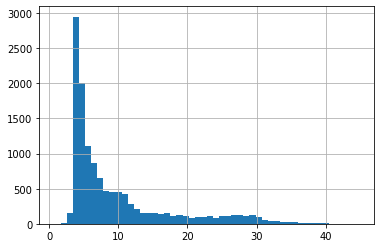

In [19]:
dm['Total'].hist(bins=50)